# Detecting moving vechiles in video 

### 1. Read the video: 

In [2]:
from IPython.display import Video

In [20]:
Video('images/AundhBridge.mp4')

### 2. Preprocessing: 

In [18]:
import sys
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

In [19]:
SCALAR_BLACK = (0.0,0.0,0.0)
SCALAR_WHITE = (255.0,255.0,255.0)
SCALAR_YELLOW = (0.0,255.0,255.0)
SCALAR_GREEN = (0.0,255.0,0.0)
SCALAR_RED = (0.0,0.0,255.0)
SCALAR_CYAN = (255.0,255.0,0.0)

In [21]:
def plot_image(images, captions=None, cmap='gray'):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    
    for image, caption, ax in zip(images, captions, axes):
        ax.imshow(image, cmap)
        ax.set_title(caption)

### 3. Capturing movement in video
**Two consecutive frames are required to capture the movement**. If there is movement in vehicle, there will be small change in pixel value in the current frame compared to the previous frame. The change implies movement. Let's capture the first 2 frames now.

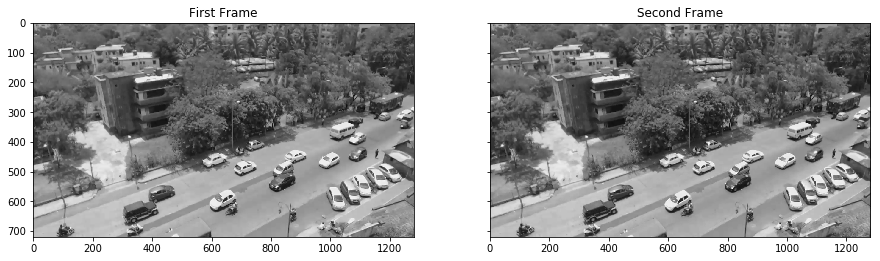

In [29]:
cap = cv2.VideoCapture('images/AundhBridge.mp4')

if  not (cap.isOpened()):
    print('not able to open')

ret, fFrame  = cap.read()

ret, frame1 = cap.read()
ret, frame2 = cap.read()

image1 = frame1.copy()
image2 = frame2.copy()

image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

plot_image([image1, image2], captions=['First Frame', 'Second Frame'], cmap='gray')

### 4. Adding gaussion blur for smoothening

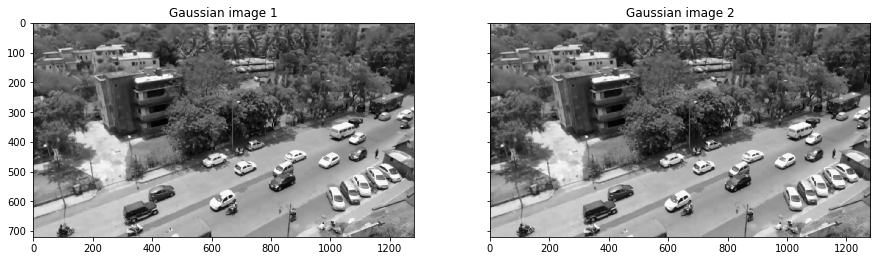

In [31]:
gaussian_1 = cv2.GaussianBlur(image1, (5, 5), 0)
gaussian_2 = cv2.GaussianBlur(image2, (5, 5), 0)
plot_image([gaussian_1, gaussian_2], captions=['Gaussian image 1', 'Gaussian image 2'])

### 5. Find the movement in video
If vehicle is moving, there will be **slight change** in pixel value in the next frame compared to previous frame. We then threshold the image. This will be useful further for preprocessing. Pixel value below 30 will be set as 0(black) and above as 255(white)

Thresholding: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html

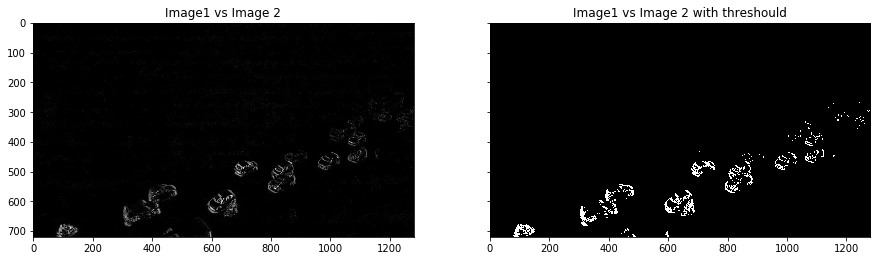

In [36]:
imageDiff = cv2.absdiff(image1, image2)
ret,imgThresh = cv2.threshold(imageDiff,30.0,255.0,cv2.THRESH_BINARY)
ht = np.size(imgThresh,0)
wd = np.size(imgThresh,1)
plot_image([imageDiff, imgThresh], captions=['Image1 vs Image 2', 'Image1 vs Image 2 with threshould'], cmap='gray')

##### Dilation and erosion in image:

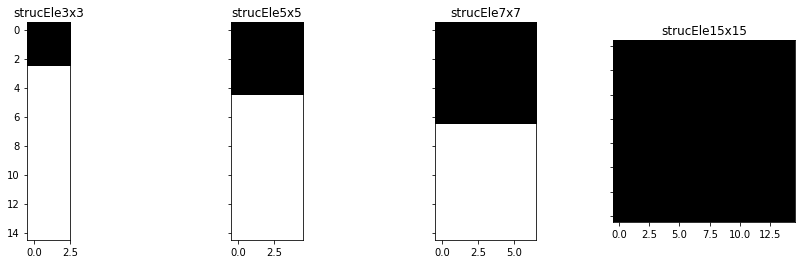

In [37]:
strucEle3x3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
strucEle5x5 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
strucEle7x7 = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))        
strucEle15x15 = cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))

plot_image([strucEle3x3, strucEle5x5, strucEle7x7, strucEle15x15], cmap='gray', captions = ["strucEle3x3", "strucEle5x5", "strucEle7x7", "strucEle15x15"])


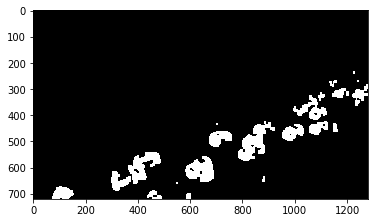

In [38]:
for i in range(2):
    imgThresh = cv2.dilate(imgThresh,strucEle5x5,iterations = 2)
    imgThresh = cv2.erode(imgThresh,strucEle5x5,iterations = 1)

    imgThreshCopy = imgThresh.copy()

plt.imshow(imgThresh, cmap = 'gray')

### 6. Extracting contours
Till now, you have a binary image. Next, we will segment the image and find all possible contours(possible vehicles). The shape of the contours will tell us the number of contours that has been identified. Define *drawAndShowContours()* function to plot the contours. You will see that the threshold image above and the countour image will look alike. So, additionally, we also plot a particular '9th' countour for further clarity. 

In [41]:
def drawAndShowContours(wd,ht,contours,strImgName):
    global SCALAR_WHITE
    blank_image = np.zeros((ht,wd,3), np.uint8)
    cv2.drawContours(blank_image,contours,-1,SCALAR_WHITE,-1)
    blank_image_contour_9 = np.zeros((ht,wd,3), np.uint8)
    
    cv2.drawContours(blank_image_contour_9,contours,8,SCALAR_WHITE,-1)
    
    plot_image([blank_image, blank_image_contour_9], cmap='gray', captions = ["All possible contours", "Only the 9th contour"])
        
    return blank_image

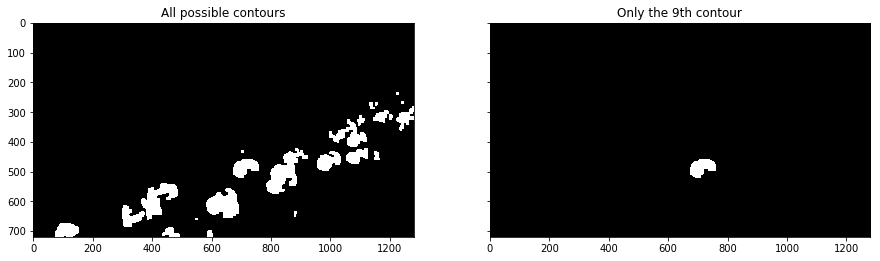

In [42]:
im, contours, hierarchy = cv2.findContours(imgThreshCopy,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
im2 = drawAndShowContours(wd,ht,contours,'imgContours')

## Hulls
Hulls are contours with the "convexHull".

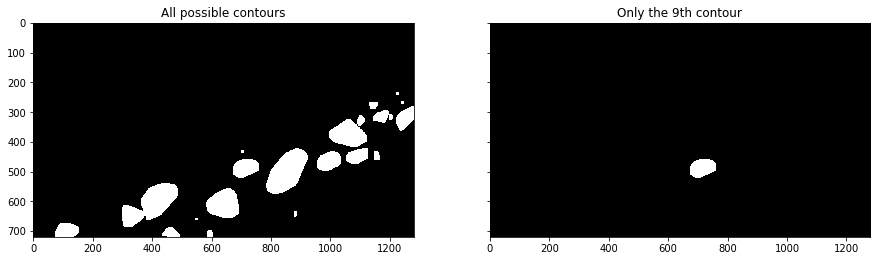

In [43]:
hulls = contours

for i in range(len(contours)):
    hulls[i] = cv2.convexHull(contours[i])

im3 = drawAndShowContours(wd,ht,hulls,'imgConvexHulls')

========> define the OOOPS way

In [57]:
SHOW_DEBUG_STEPS = False

drag = 0
select_flag = 0

x1, y1, x2, y2 = 0, 0, 1, 2
point1, point2 = [x1, y1], [x2, y2]

# This is a matrix version of the same two points
crossingLine = np.zeros((2,2),np.int)
crossingLine[0] = point1
crossingLine[1] = point2

frameCnt = 2
callback = False
vehicleCount = 0
src_window='Vehicle Counting - Blob Save'

# This is a variable that keeps track of how many blobs have been cropped
u=0

# Here, we define some colours
SCALAR_BLACK = (0.0,0.0,0.0)
SCALAR_WHITE = (255.0,255.0,255.0)
SCALAR_YELLOW = (0.0,255.0,255.0)
SCALAR_GREEN = (0.0,255.0,0.0)
SCALAR_RED = (0.0,0.0,255.0)
SCALAR_CYAN = (255.0,255.0,0.0)

In the next cell, we define the 'Blob' class. 

This has two functions as a part of it: 

- 'Blob', which defines a blob object
- 'predictNextPosition', which predicts the position of the blob in the next frame. This is useful for keeping track that given a frame and a blob, is it a new blob or a previously detected one.

In [95]:
# ====> Blob 
class Blob():
    
    currentContour = [[0,0]]
    x=0
    y=0
    w=0
    h=0
    currentBoundingRect = [x,y,w,h] # = cv2.boundingRect(_contour)
    centerPositions = [0,0]
    currentDiagonalSize = 0.0
    currentAspectRatio = 0.0
    currentMatchFoundOrNewBlob = False
    stillBeingTracked = False
    NumOfConsecutiveFramesWithoutAMatch = 0
    predictedNextPosition = np.zeros((1,2),np.int)
    
    def Blob(self, _contour):
        self.currentContour = _contour
        currentCenter = [0,0]
        
        self.currentBoundingRect = cv2.boundingRect(_contour)
        currentCenter[0] = self.currentBoundingRect[0] + self.currentBoundingRect[2] / 2
        currentCenter[1] = self.currentBoundingRect[1] + self.currentBoundingRect[2] / 2
        self.centerPositions.append(currentCenter)
        self.currentDiagonalSize = math.sqrt( math.pow(self.currentBoundingRect[2], 2) + math.pow(self.currentBoundingRect[3] , 2) )
        self.currentAspectRatio = float(self.currentBoundingRect[2]) / float(self.currentBoundingRect[3])

        self.stillBeingTracked = True
        self.currentMatchFoundOrNewBlob = True
        self.NumOfConsecutiveFramesWithoutAMatch = 0

In [59]:

blob = Blob()
blobs = [blob]


In [104]:
# ====> 

def closeAll():
    # ===> cv2 close windows
    # ===> video capture stop
    cap.release()
    cv2.destroyAllWindow()
    return

def retn(ret):
    # ===> check if the video is corrupted
    if not ret == True:
        print('Error while reading the video')
        closeAll()

def isFrameCorrect(frame):
    # ===> check if drawing correct
    if frame is None: 
        print('Frame corrected while reading')
        closeAll()

def drawLine(frame):
    global point1
    global point2
    global SCALAR_YELLOW
    cv2.line(frame, (point1[0], point1[1]), (point2[0], point2[1]), SCALAR_YELLOW, 2, 8)

def myMouseHandler(event, x, y, flags, param):
    global point1
    global point2
    global drag
    global select_flag
    global callback
    
    if (event == cv2.EVENT_LBUTTONDOWN and not(drag) and not(select_flag)):
        point1 = [x, y]
        drag = 1
    elif (event == cv2.EVENT_MOUSEMOVE and drag and not(select_flag)):
        img1 = fFrame.copy()
        point2 = [x, y]
        drawLine(fFrame)
        cv2.imshow(src_window, img1)
        print('Image 1 shape', img1.shape)
        
    elif (event == cv2.EVENT_LBUTTONUP and drag and not(select_flag)):
        point2 = [x, y]
        img2 = fFrame.copy()
        print('Image 2 shape', img2.shape)
        select_flag = 1
        drag = 0
        callback = 1
        cv2.imshow(src_window,img2)
    

def drawAndShowContours(wd,ht,contours,strImgName):
    global SCALAR_WHITE
    global SHOW_DEBUG_STEPS
    blank_image = np.zeros((ht,wd,3), np.uint8)
    cv2.drawContours(blank_image,contours,-1,SCALAR_WHITE,-1)
    
    if(SHOW_DEBUG_STEPS):
        cv2.imshow(strImgName,blank_image)
    return blank_image

def drawAndShowBlobs(wd,ht,blobs,strImgName):
    global SCALAR_WHITE
    global SHOW_DEBUG_STEPS
    blank_image = np.zeros((ht,wd,3), np.uint8)
    
    contours=[]
    for blob in blobs:
        if blob.stillBeingTracked == True:
            contours.append(blob.currentContour)
            
    cv2.drawContours(blank_image,contours,-1,SCALAR_WHITE,-1)
    
    if(SHOW_DEBUG_STEPS):
        cv2.imshow(strImgName,blank_image)
    return blank_image

In [105]:
cap = cv2.VideoCapture('images/AundhBridge.mp4')

if not (cap.isOpened()):
    print('Video corrupted')

ref, fFrame = cap.read()
retn(ref)
isFrameCorrect(fFrame)

fGray = cv2.cvtColor(fFrame, cv2.COLOR_BGR2GRAY)
cv2.imshow(src_window, fFrame)

ret, frame1 = cap.read()
ret, frame2 = cap.read()

print('shape of frame 1', frame1.shape)
print('shape of frame 2', frame2.shape)

cv2.setMouseCallback(src_window, myMouseHandler)

chChkEscKey = 0  
k = 27    
blnFirstFrame = True
frameCnt = 2

shape of frame 1 (720, 1280, 3)
shape of frame 2 (720, 1280, 3)


In [106]:
count = 0

In [107]:
help(cv2.findContours)

Help on built-in function findContours:

findContours(...)
    findContours(image, mode, method[, contours[, hierarchy[, offset]]]) -> image, contours, hierarchy
    .   @brief Finds contours in a binary image.
    .   
    .   The function retrieves contours from the binary image using the algorithm @cite Suzuki85 . The contours
    .   are a useful tool for shape analysis and object detection and recognition. See squares.cpp in the
    .   OpenCV sample directory.
    .   @note Since opencv 3.2 source image is not modified by this function.
    .   
    .   @param image Source, an 8-bit single-channel image. Non-zero pixels are treated as 1's. Zero
    .   pixels remain 0's, so the image is treated as binary . You can use #compare, #inRange, #threshold ,
    .   #adaptiveThreshold, #Canny, and others to create a binary image out of a grayscale or color one.
    .   If mode equals to #RETR_CCOMP or #RETR_FLOODFILL, the input can also be a 32-bit integer image of labels (CV_32SC1).
   

In [ ]:
while (cap.isOpened()):
    if (count < 3):
        print('count', count)
        currentFrameBlob = Blob()
        currentFrameBlobs = [currentFrameBlob]

        img1 = frame1.copy()
        img2 = frame2.copy()

        if (SHOW_DEBUG_STEPS):
            print("Shape of image 1", img1.shape)
            print("Shape of image 2", img2.shape)

        # ===> convert to Gray scale
        print('At Gray scaling of image')
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        # ===> apply gaussian filter
        print('At gaussian filter of image')
        img1 = cv2.GaussianBlur(img1, (5, 5), 0)
        img2 = cv2.GaussianBlur(img2, (5, 5), 0)

        # ===> apply difference b/w the images and apply threshoulding
        diff = cv2.absdiff(img1, img2)
        ret, threshouldImg = cv2.threshold(diff, 30.0, 255.0,
                                           cv2.THRESH_BINARY)

        ht = np.size(imgThresh, 0)
        wd = np.size(imgThresh, 1)

        if (SHOW_DEBUG_STEPS):
            cv2.imshow('imgThresh', imgThresh)

        # ===> apply erosion and dilation
        print('At erosion and dilation image')
        strutureElement5X5 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

        for i in range(i):
            imgThresh = cv2.dilate(threshouldImg,
                                   strutureElement5X5,
                                   iterations=2)
            imgThresh = cv2.erode(imgThresh, strutureElement5X5, iterations=1)

        if (SHOW_DEBUG_STEPS):
            print("Threshould image shape:: ", imgThresh.shape)

        # ===> find contours
        im, contours, hierarchy = cv2.findContours(imgThresh,
                                                   cv2.RETR_EXTERNAL,
                                                   cv2.CHAIN_APPROX_SIMPLE)
        im2 = drawAndShowContours(wd, ht, contours, 'imgContours')

        if (SHOW_DEBUG_STEPS):
            print('contours.shape: ' + str(len(contours)))

        # ===> find hull's and draw
        hulls = contours
        for i in range(len(contours)):
            hulls[i] = cv2.convexHull(contours[i])
        im3 = drawAndShowContours(wd, ht, hulls, 'imgConvexHulls')
        
        count += 1

        # ===> pass each hull through blob
        for hull in hulls:
            possible = Blob()
            possible.Blob(hull)
            currentBondingRectArea = possible.currentBoundingRect[
                1] * possible.currentBoundingRect[3]
            contourAread = cv2.contourArea(hull)

            if (currentBondingRectArea > 400
                    and possible.currentAspectRatio > 0.2
                    and possible.currentAspectRatio < 4.0
                    and possible.currentBoundingRect[2] > 30
                    and possible.currentBoundingRect[3] > 30
                    and possible.currentDiagonalSize > 60.0):
                currentFrameBlobs.append(possible)
                
        im4 = drawAndShowBlobs(wd, ht, currentFrameBlobs,
                               'imgCurrentFrameBlobs')

    k = cv2.waitKey(1)
    if k == 27 or k == ord('q') or vehicleCount > 20:
        closeAll()
        break